In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
import logging

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

In [3]:
df = pd.read_csv('data/monthly_in_situ_co2_mlo.csv',
                  comment = '"', header = [0,1,2], na_values = '-99.99')

cols = [' '.join(col).replace(' ', '') for col in df.columns.values]
df.set_axis(cols, axis = 1, inplace = True)

# Converting Excel date format to datetime
# and setting as dataframe index
df['datetime'] = pd.to_datetime(df['DateExcel'], origin = '1899-12-30', unit = 'D')

df.set_index('datetime', inplace = True)

df = df[['CO2filled[ppm]']]
df.rename(columns = {'CO2filled[ppm]': 'CO2'}, inplace = True)
df.dropna(inplace = True)
df = df.resample('M').sum()

## Time Series Analysis

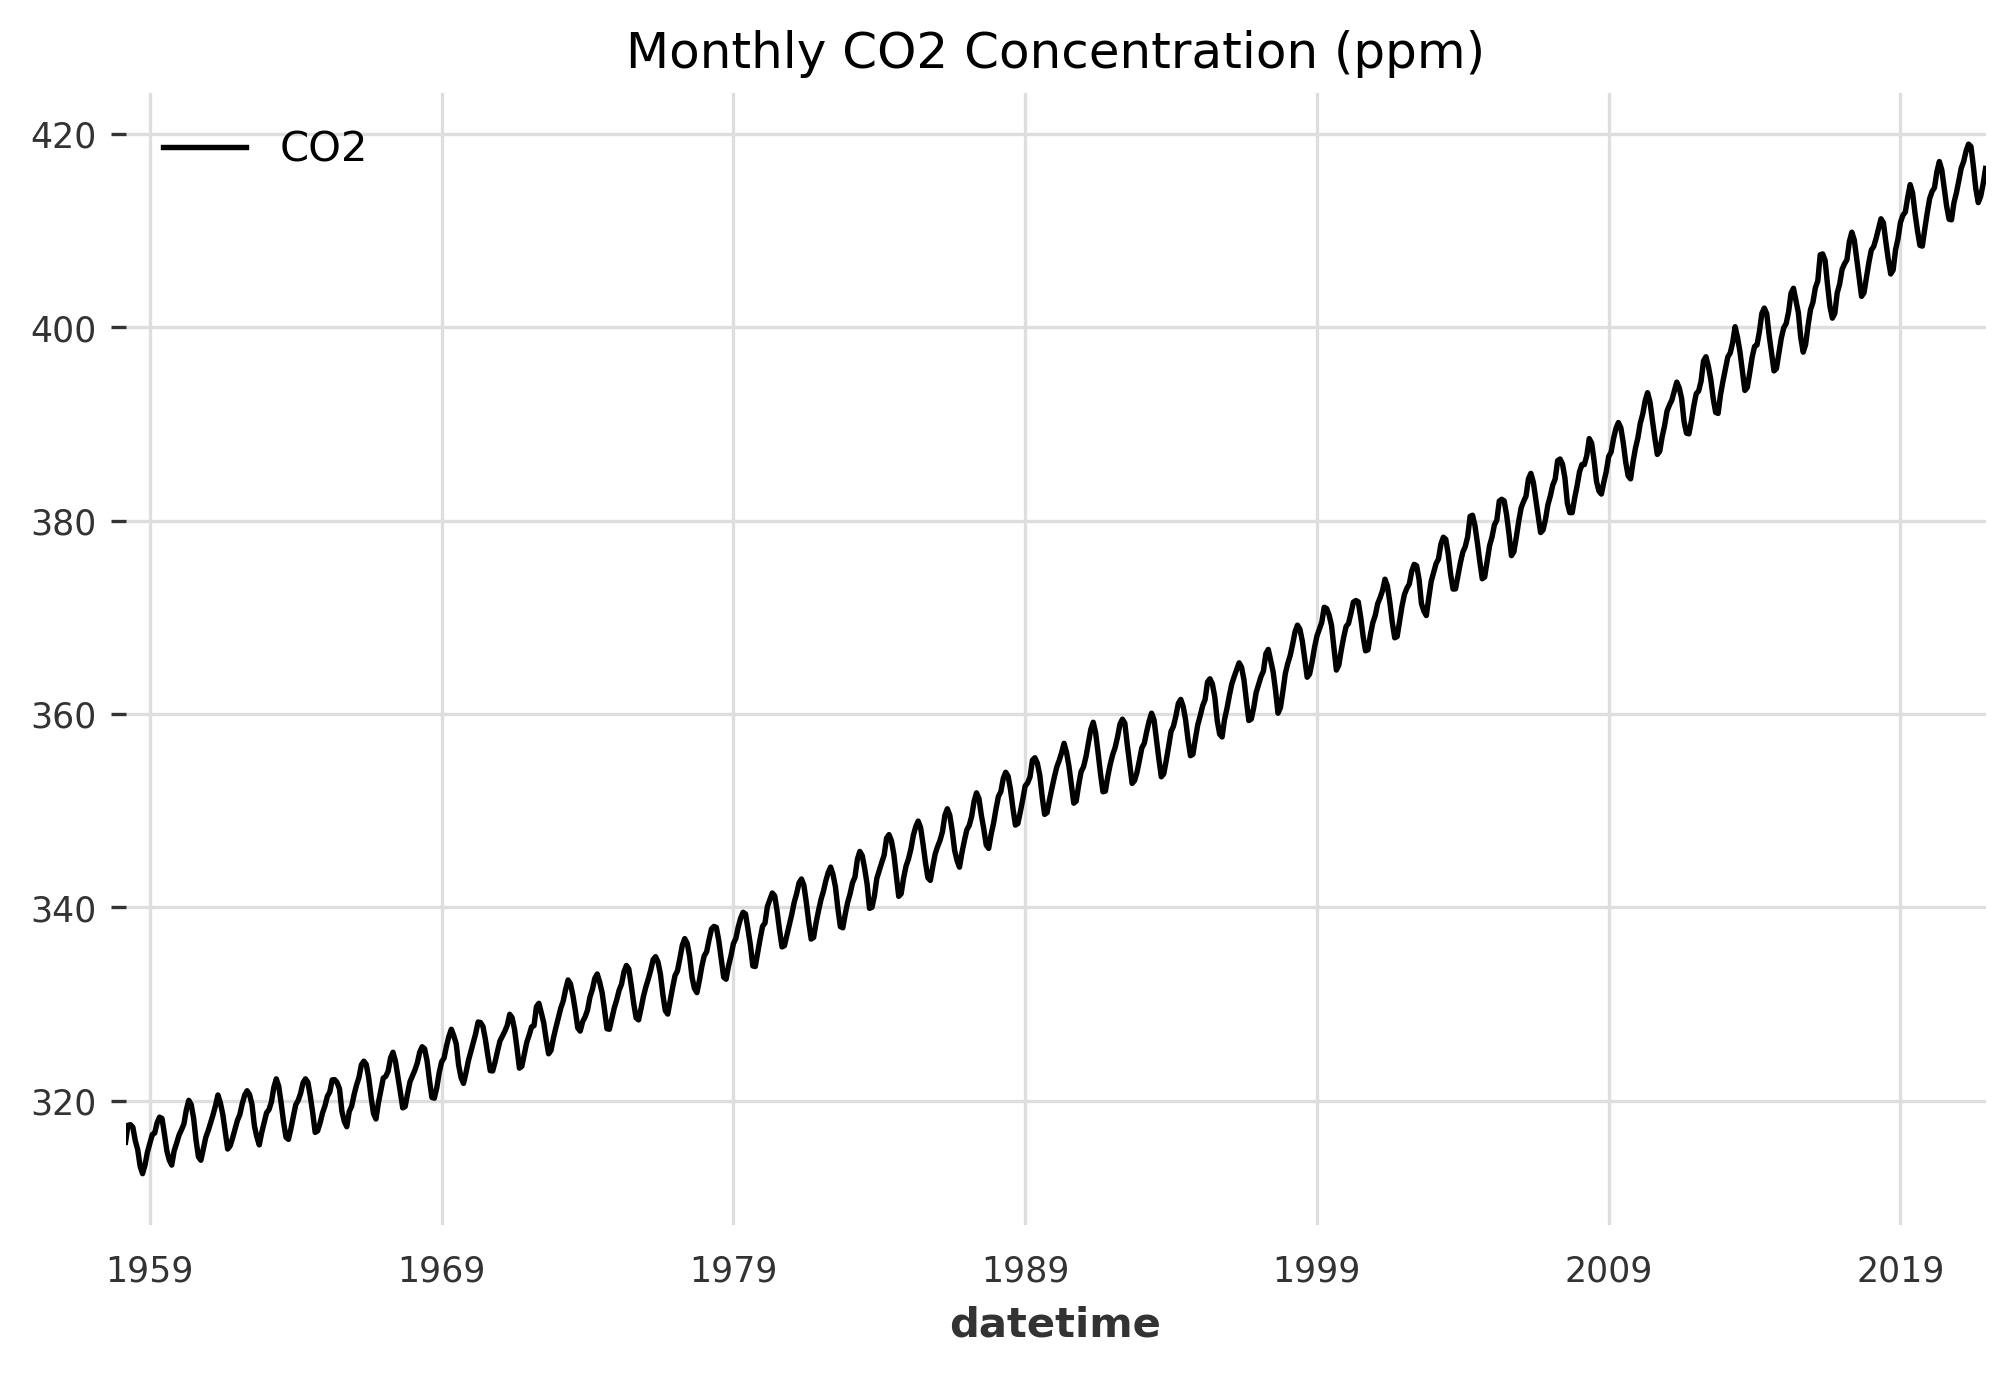

In [74]:
df.plot(figsize=(8,5))
plt.title('Monthly CO2 Concentration (ppm)')

plt.show()

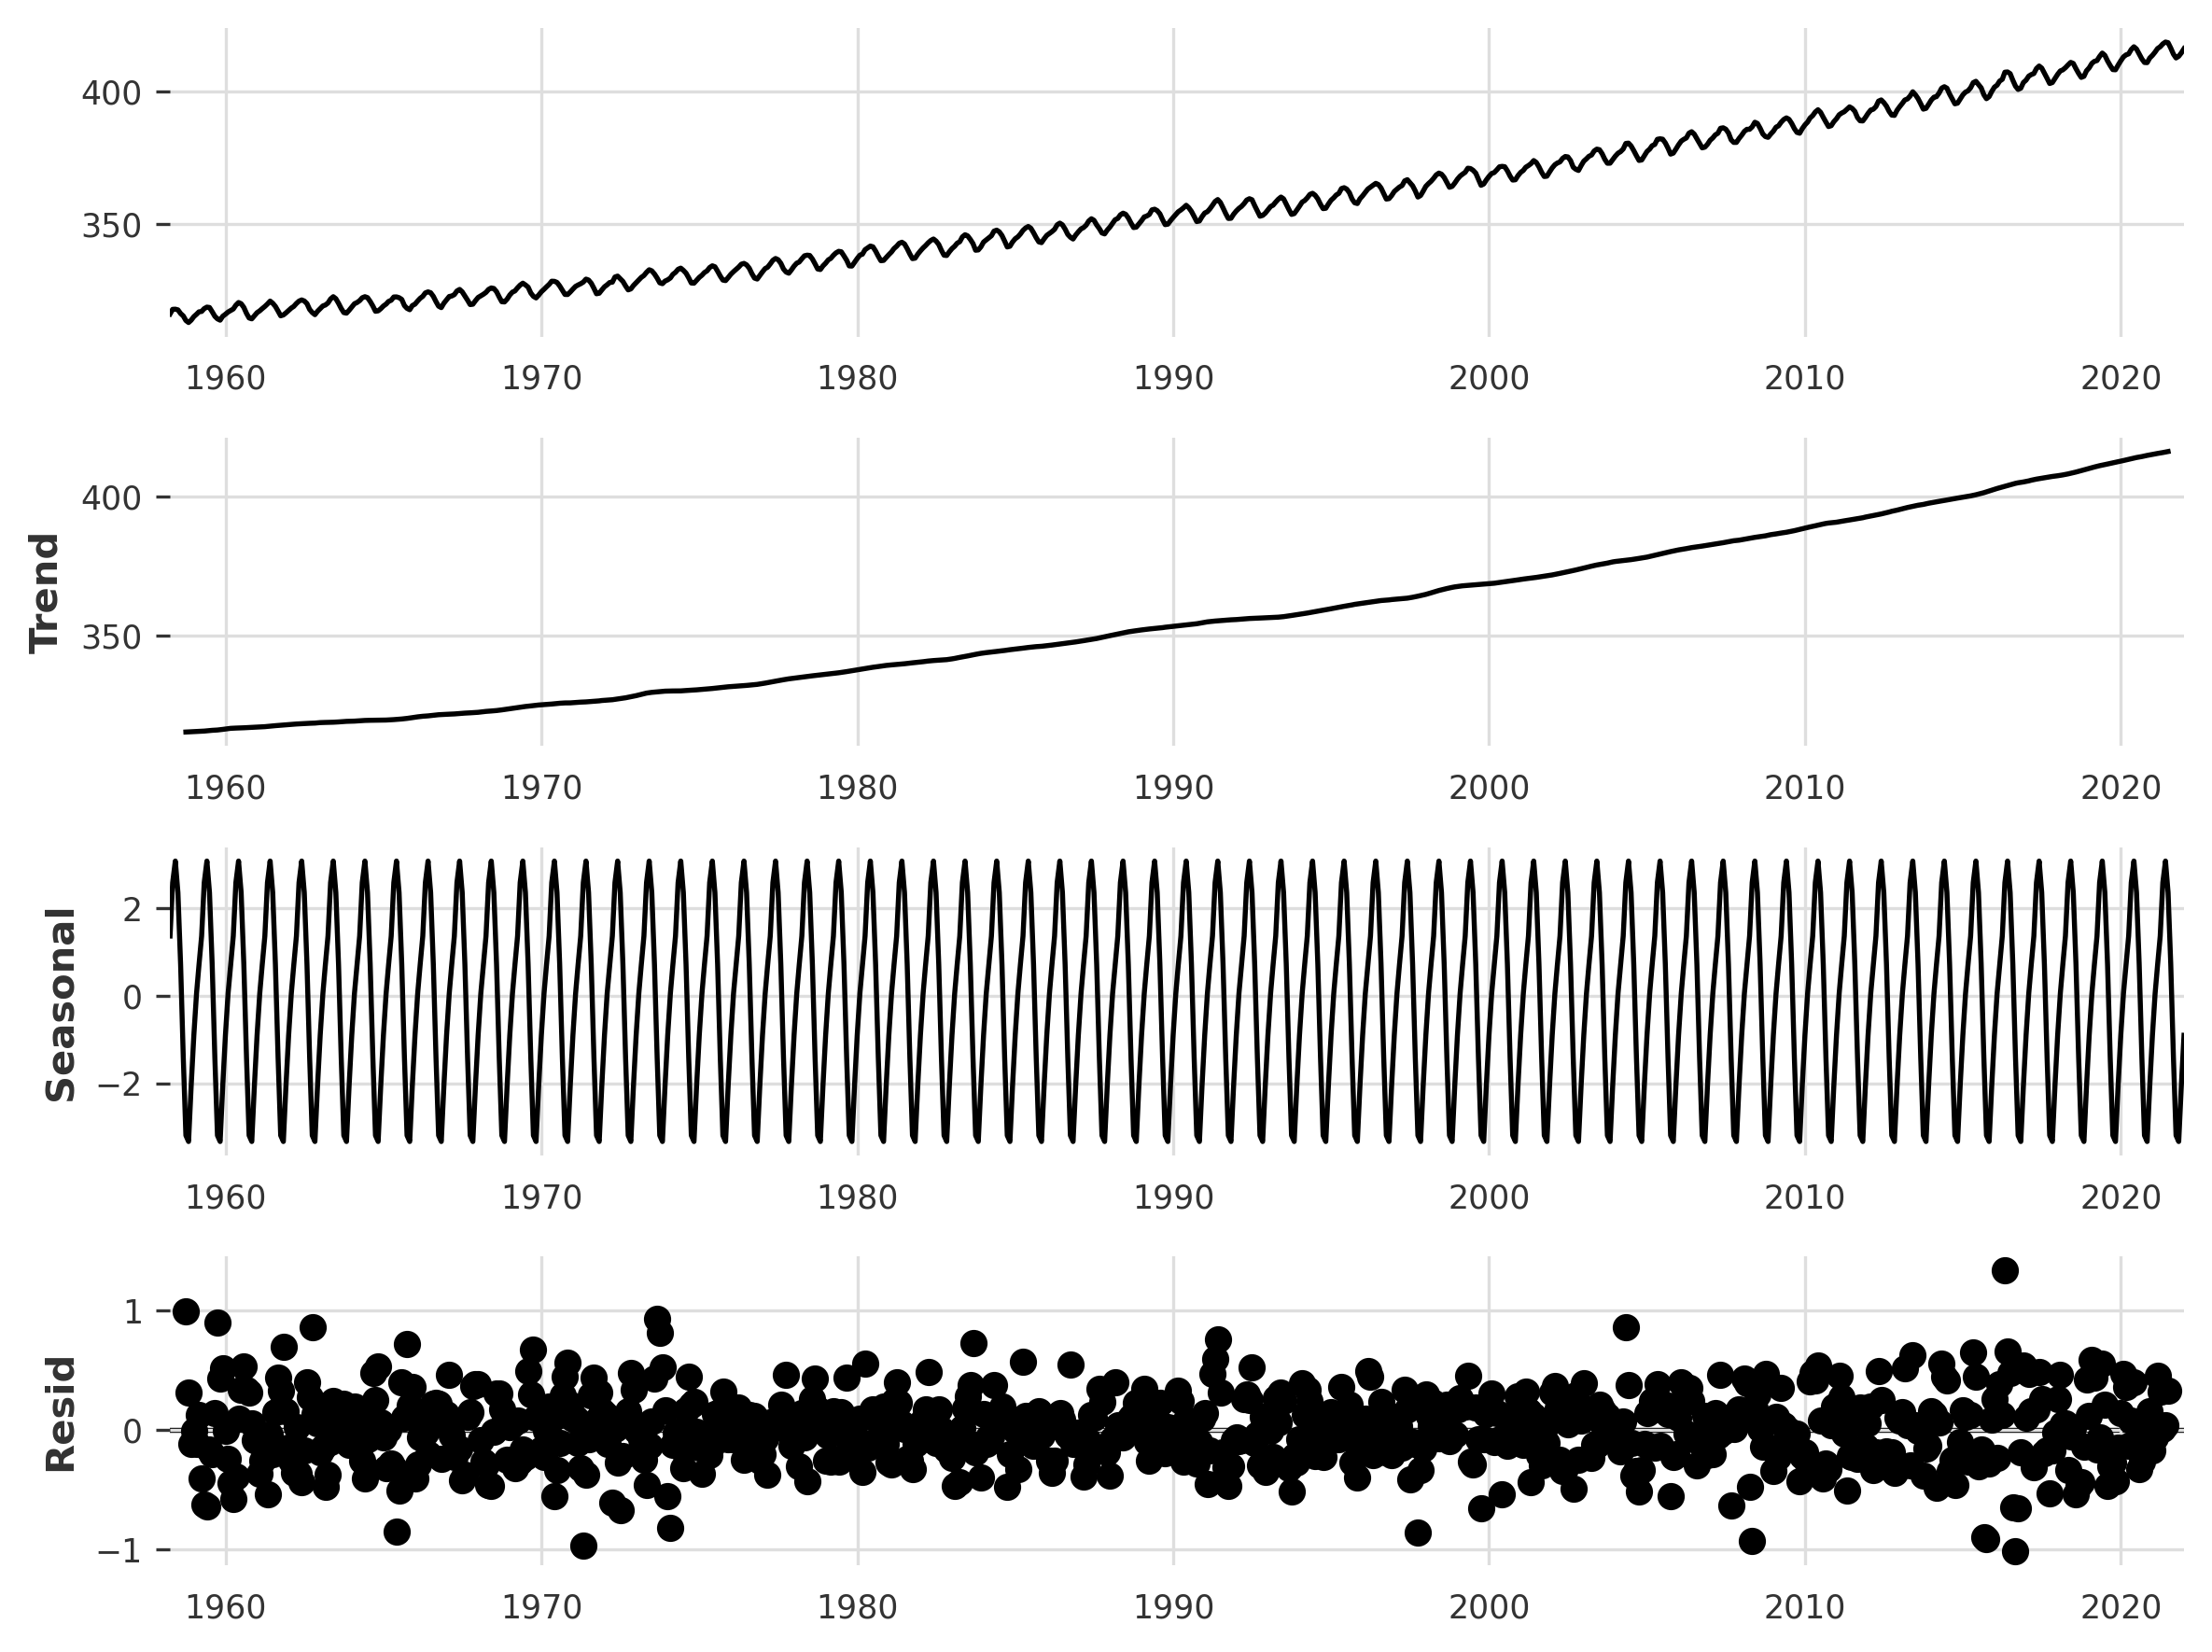

In [5]:
mpl.rcParams['figure.figsize'] = (8, 6)

result = seasonal_decompose(df)
result.plot()

plt.show()

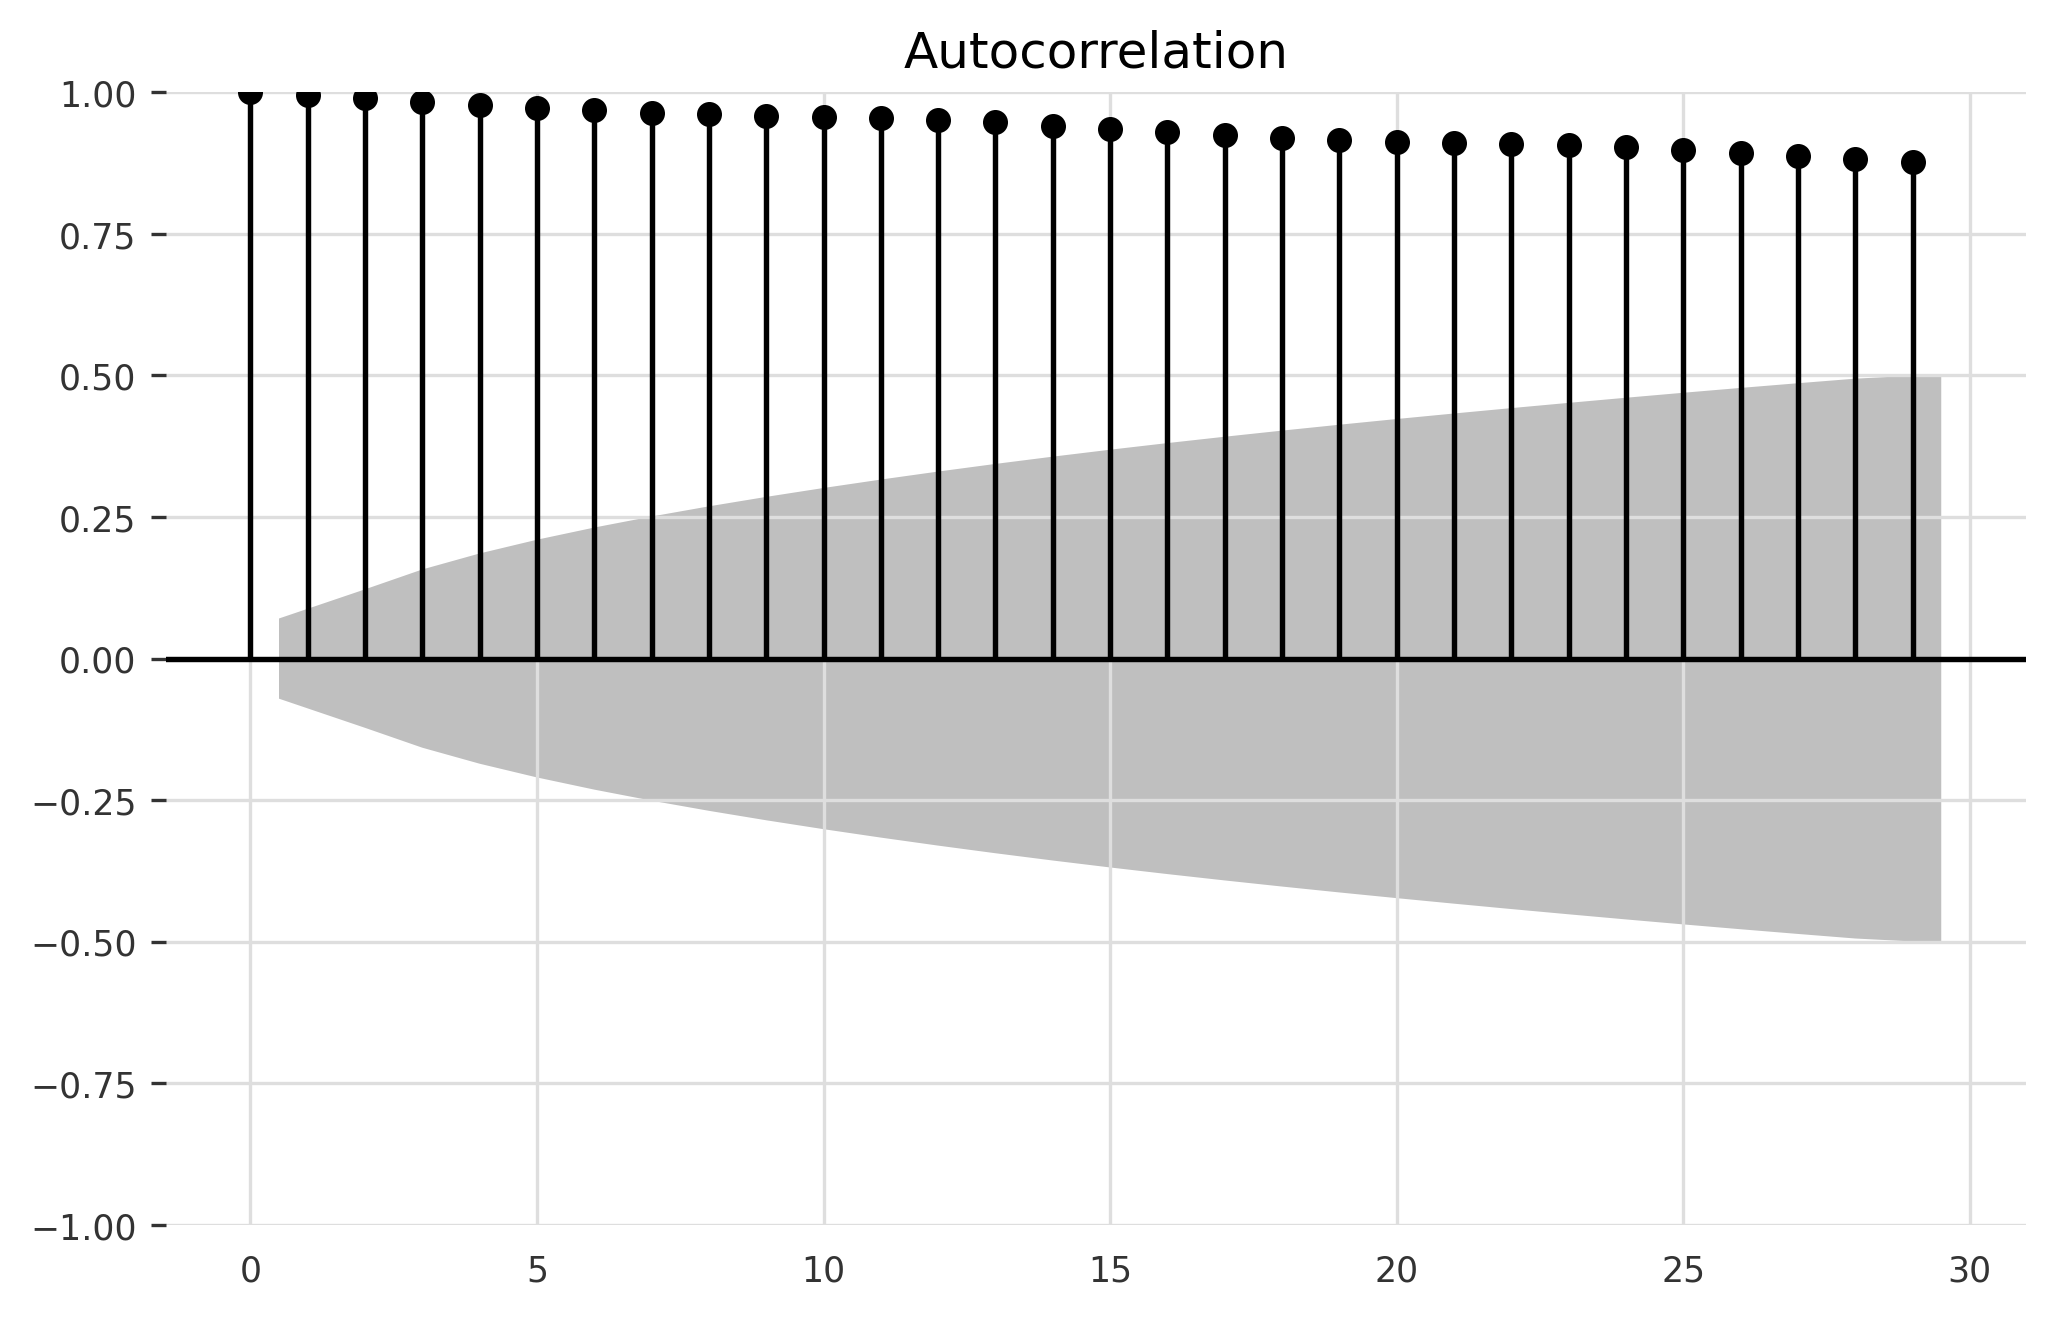

In [6]:
fig, ax = plt.subplots(figsize = (8,5))

plot_acf(df, ax = ax)

plt.show()

In [72]:
#Loading the pandas dataframe to a TimeSeries object as required by the Darts library
series = TimeSeries.from_dataframe(df)

start = pd.Timestamp('123115')
df_metrics = pd.DataFrame()

### Creating Utility Functions

In [43]:
def plot_backtest(series, forecast, model_name):
    idx = -144
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()
    
def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)
    
    dict_ = {'MAE': mae_, 'RMSE': rmse_,
             'MAPE': mape_, 'SMAPE': smape_, 
             'R2': r2_score_}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    return(df.round(decimals = 2))       
    

### Creating a Naive Forecasting Model

  0%|          | 0/62 [00:00<?, ?it/s]

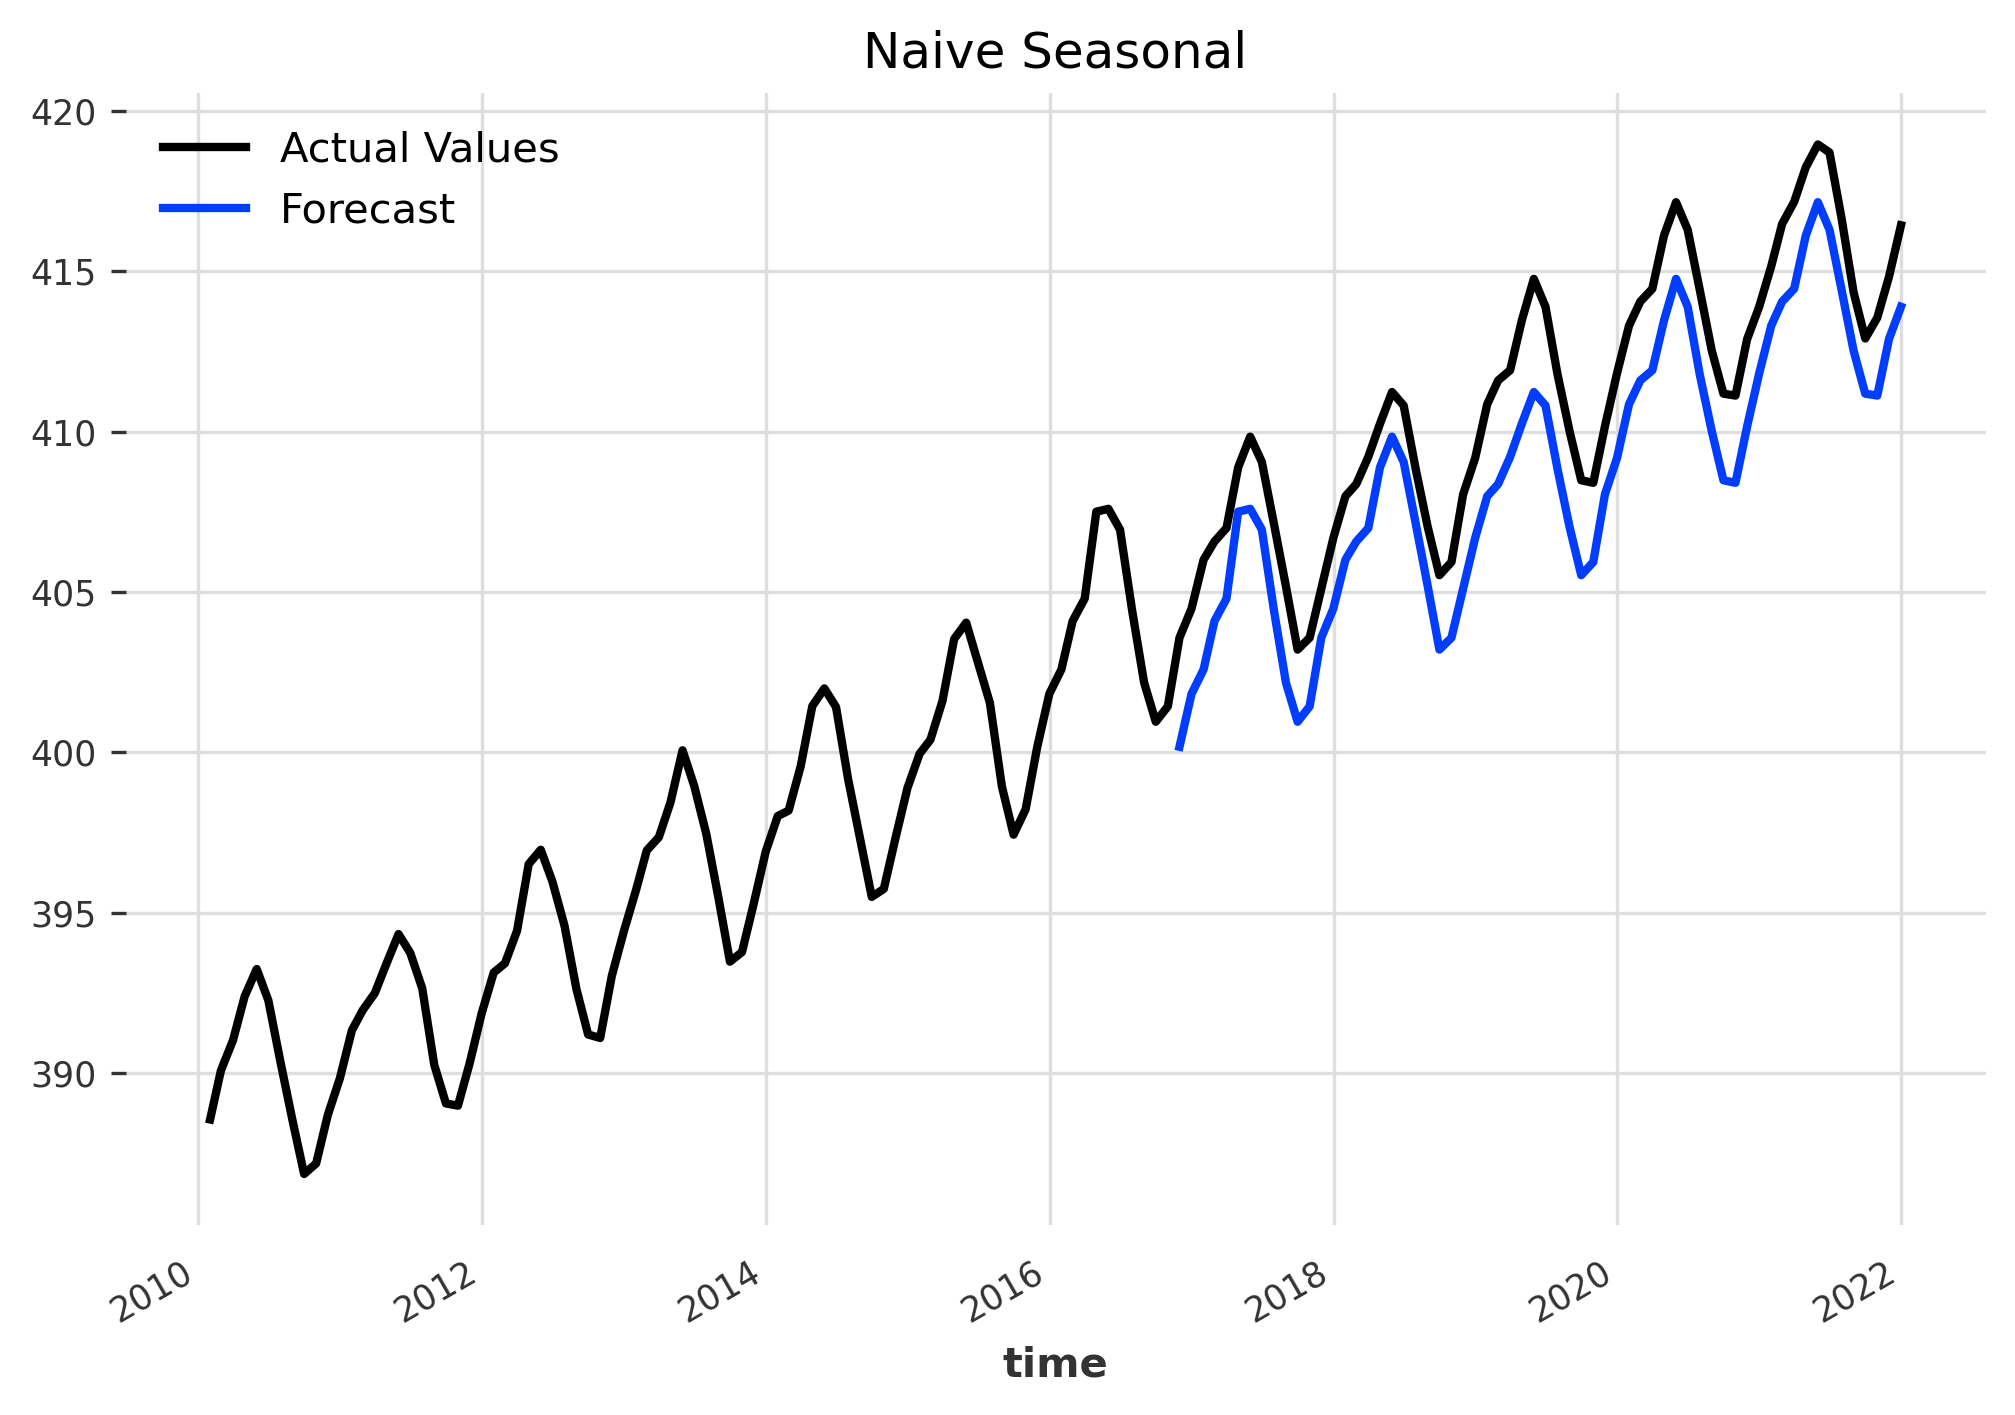

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.4,2.45,0.58,0.59,0.64


In [44]:
model = NaiveSeasonal(K = 12)
model_name = 'Naive Seasonal'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_naive = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_naive)

plt.show()
df_naive

### Creating an Exponential Smoothing Forecasting Model

  0%|          | 0/62 [00:00<?, ?it/s]

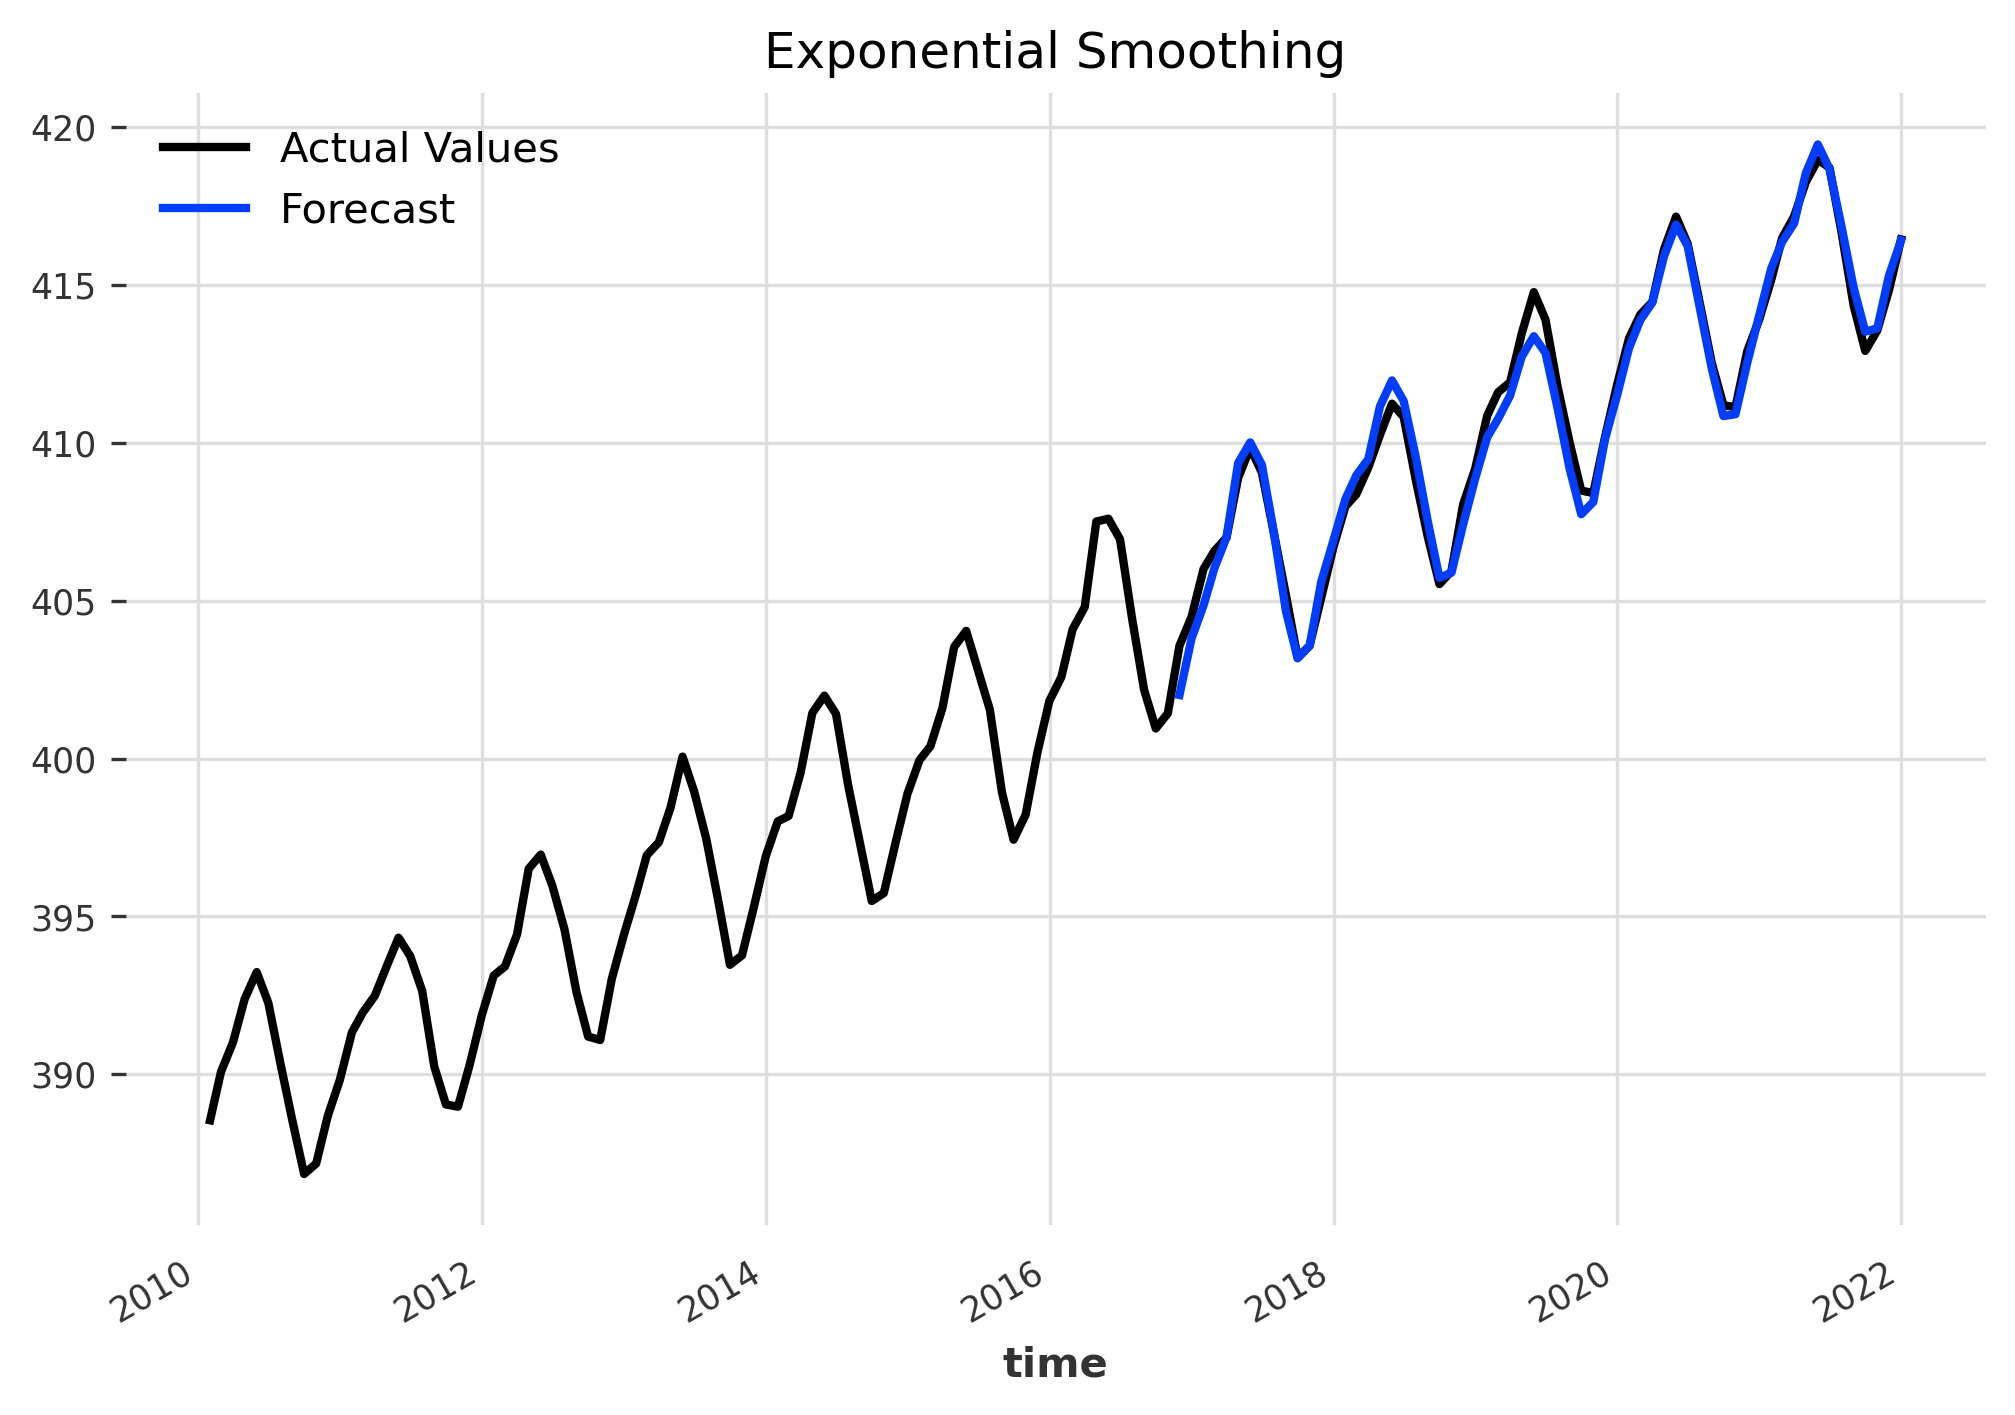

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing,0.41,0.53,0.1,0.1,0.98


In [45]:
model = ExponentialSmoothing(seasonal_periods = 12)
model_name = 'Exponential Smoothing'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_exp = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_exp)

plt.show()
df_exp

### Creating a Linear Regression Forecasting Model

  0%|          | 0/62 [00:00<?, ?it/s]

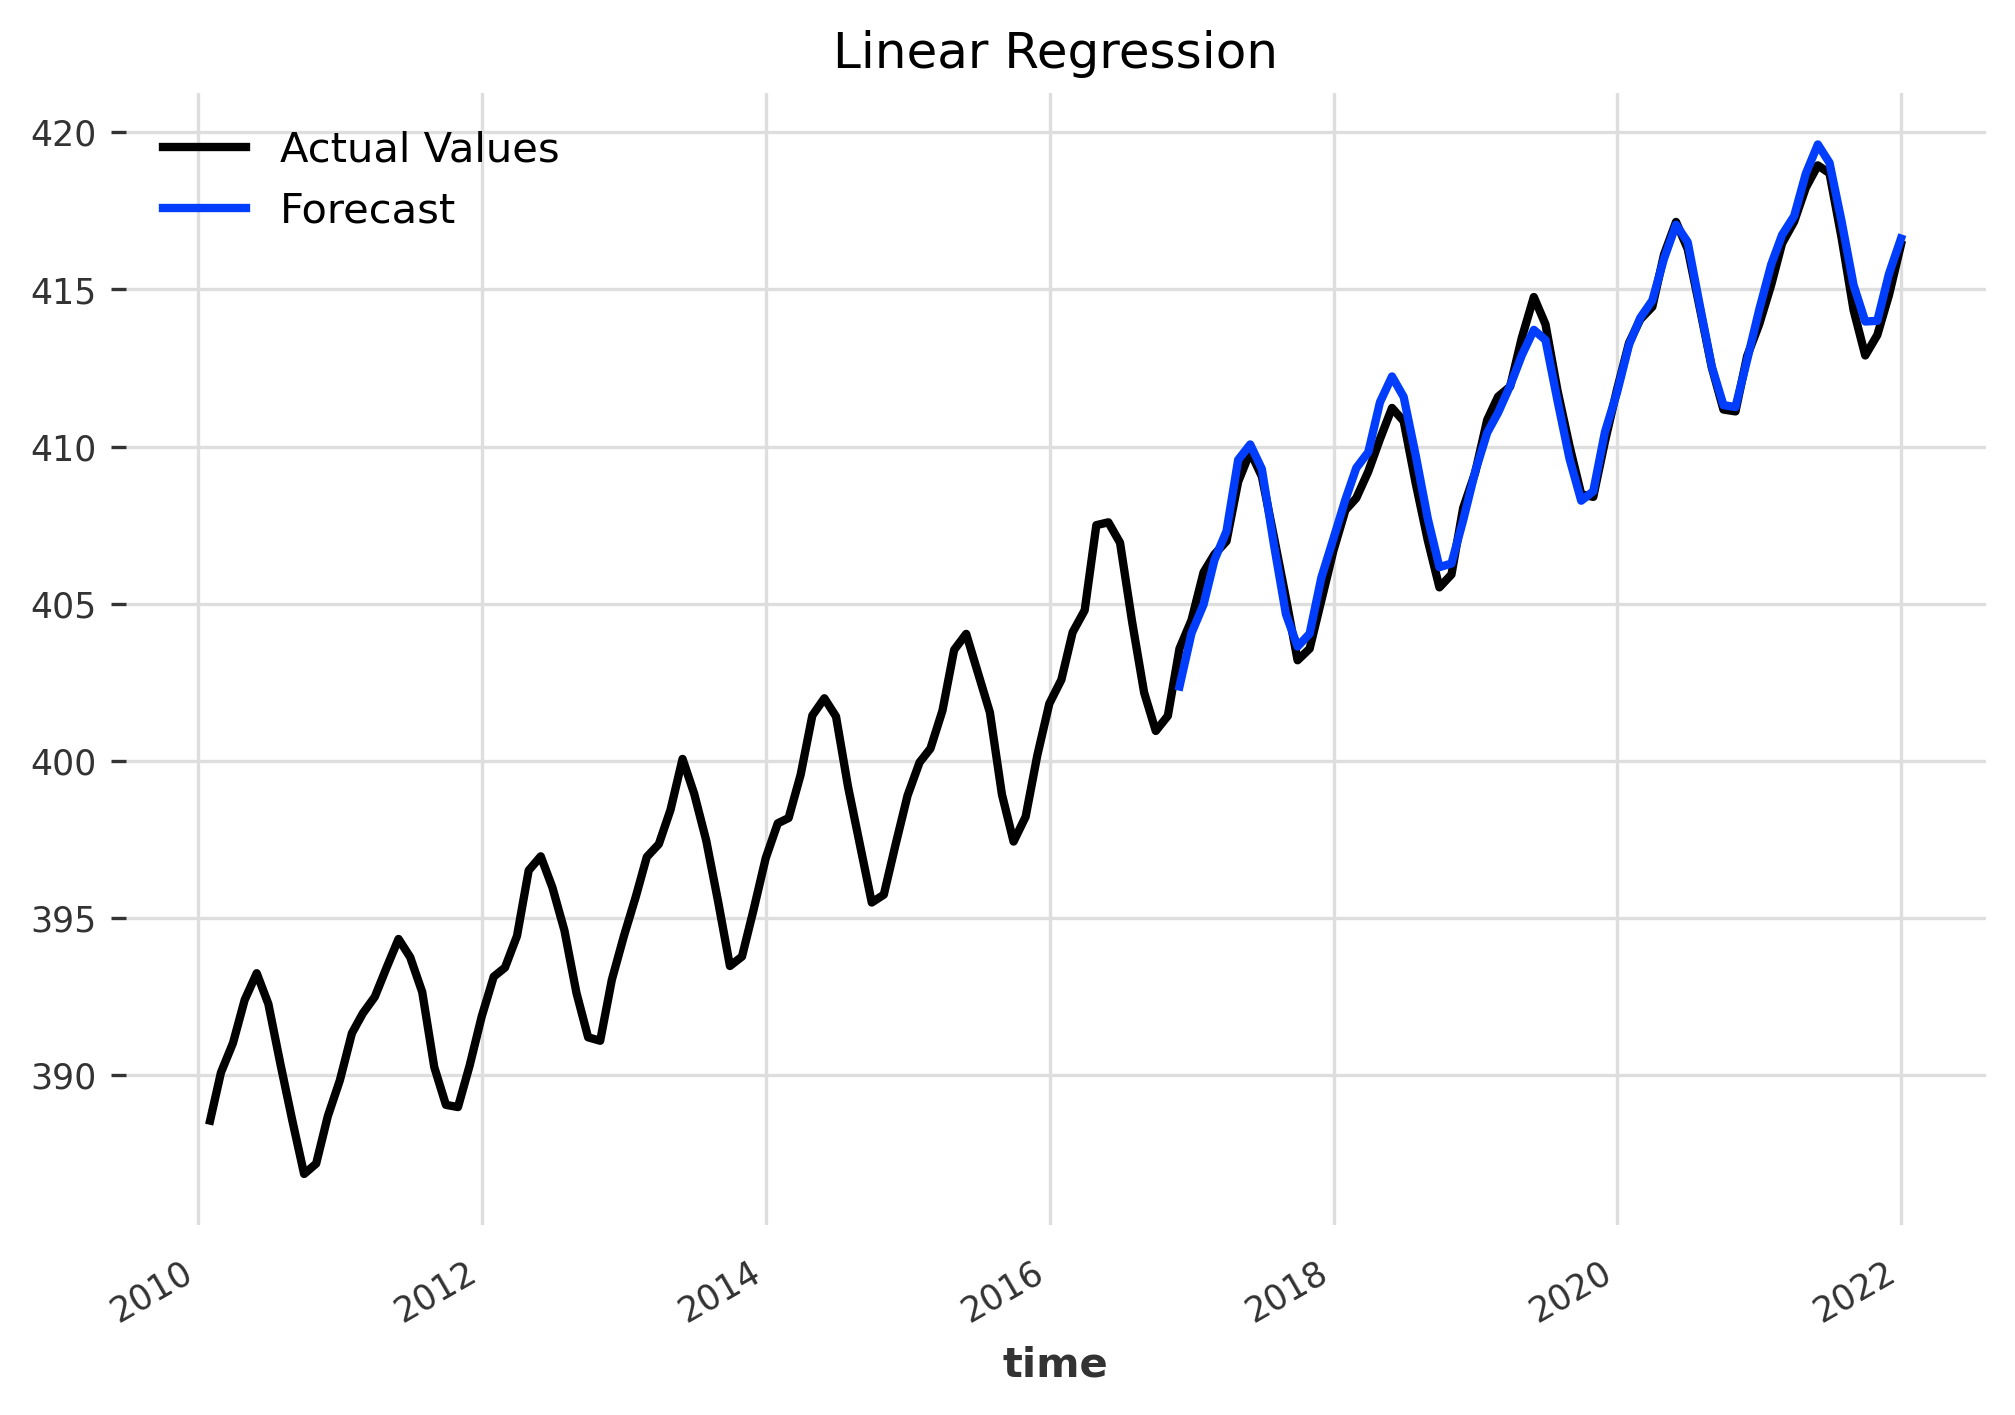

,MAE,RMSE,MAPE,SMAPE,R2
Linear Regression,0.44,0.54,0.11,0.11,0.98


In [46]:
model = LinearRegressionModel(lags = 12)
model_name = 'Linear Regression'

plt.figure(figsize = (8, 5))

forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
plot_backtest(series, forecast, model_name)
df_lr = print_metrics(series, forecast, model_name)
df_metrics = df_metrics.append(df_lr)

plt.show()
df_lr

### Creating a DL Forecasting Model

  0%|          | 0/62 [00:00<?, ?it/s]

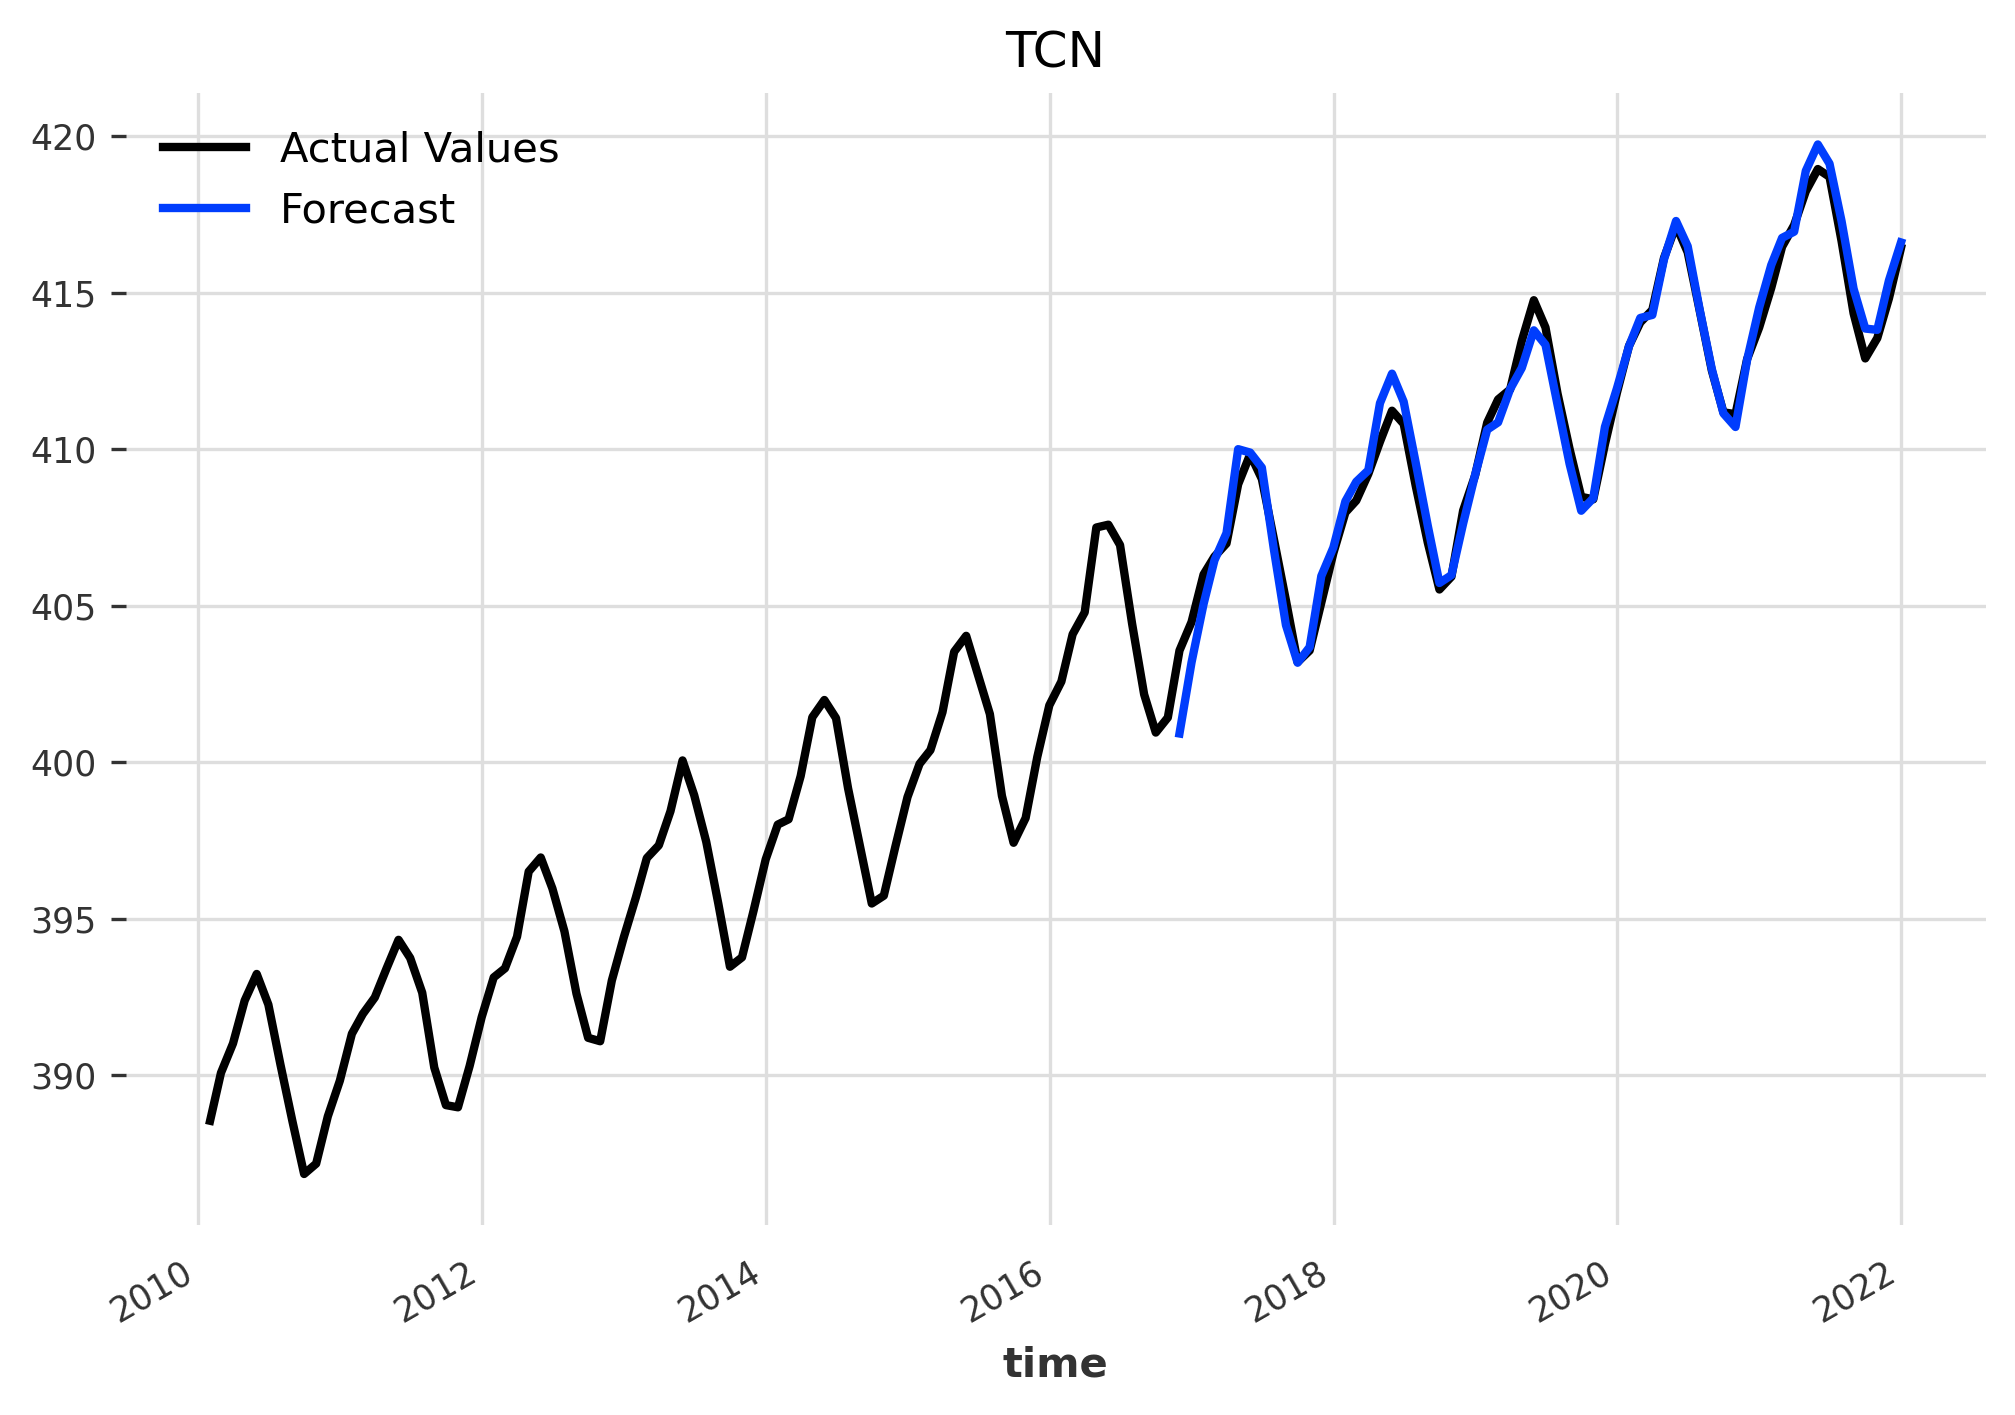

,MAE,RMSE,MAPE,SMAPE,R2
TCN,0.47,0.65,0.11,0.11,0.98


In [47]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=100,
    dropout=0.1,
    dilation_base=3,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

model_name = 'TCN'

plt.figure(figsize = (8, 5))

scaler = Scaler()
scaled_series = scaler.fit_transform(series)
forecast = model.historical_forecasts(scaled_series, start=start,
                                      forecast_horizon=12, verbose=True)
plot_backtest(series, scaler.inverse_transform(forecast), model_name)
df_dl = print_metrics(series, scaler.inverse_transform(forecast), model_name)
df_metrics = df_metrics.append(df_dl)

plt.show()
df_dl

In [50]:
df_metrics

,MAE,RMSE,MAPE,SMAPE,R2
Naive Seasonal,2.40,2.45,0.58,0.59,0.64
Exponential Smoothing,0.41,0.53,0.10,0.10,0.98
Linear Regression,0.44,0.54,0.11,0.11,0.98
TCN,0.47,0.65,0.11,0.11,0.98


### Creating a Forecast

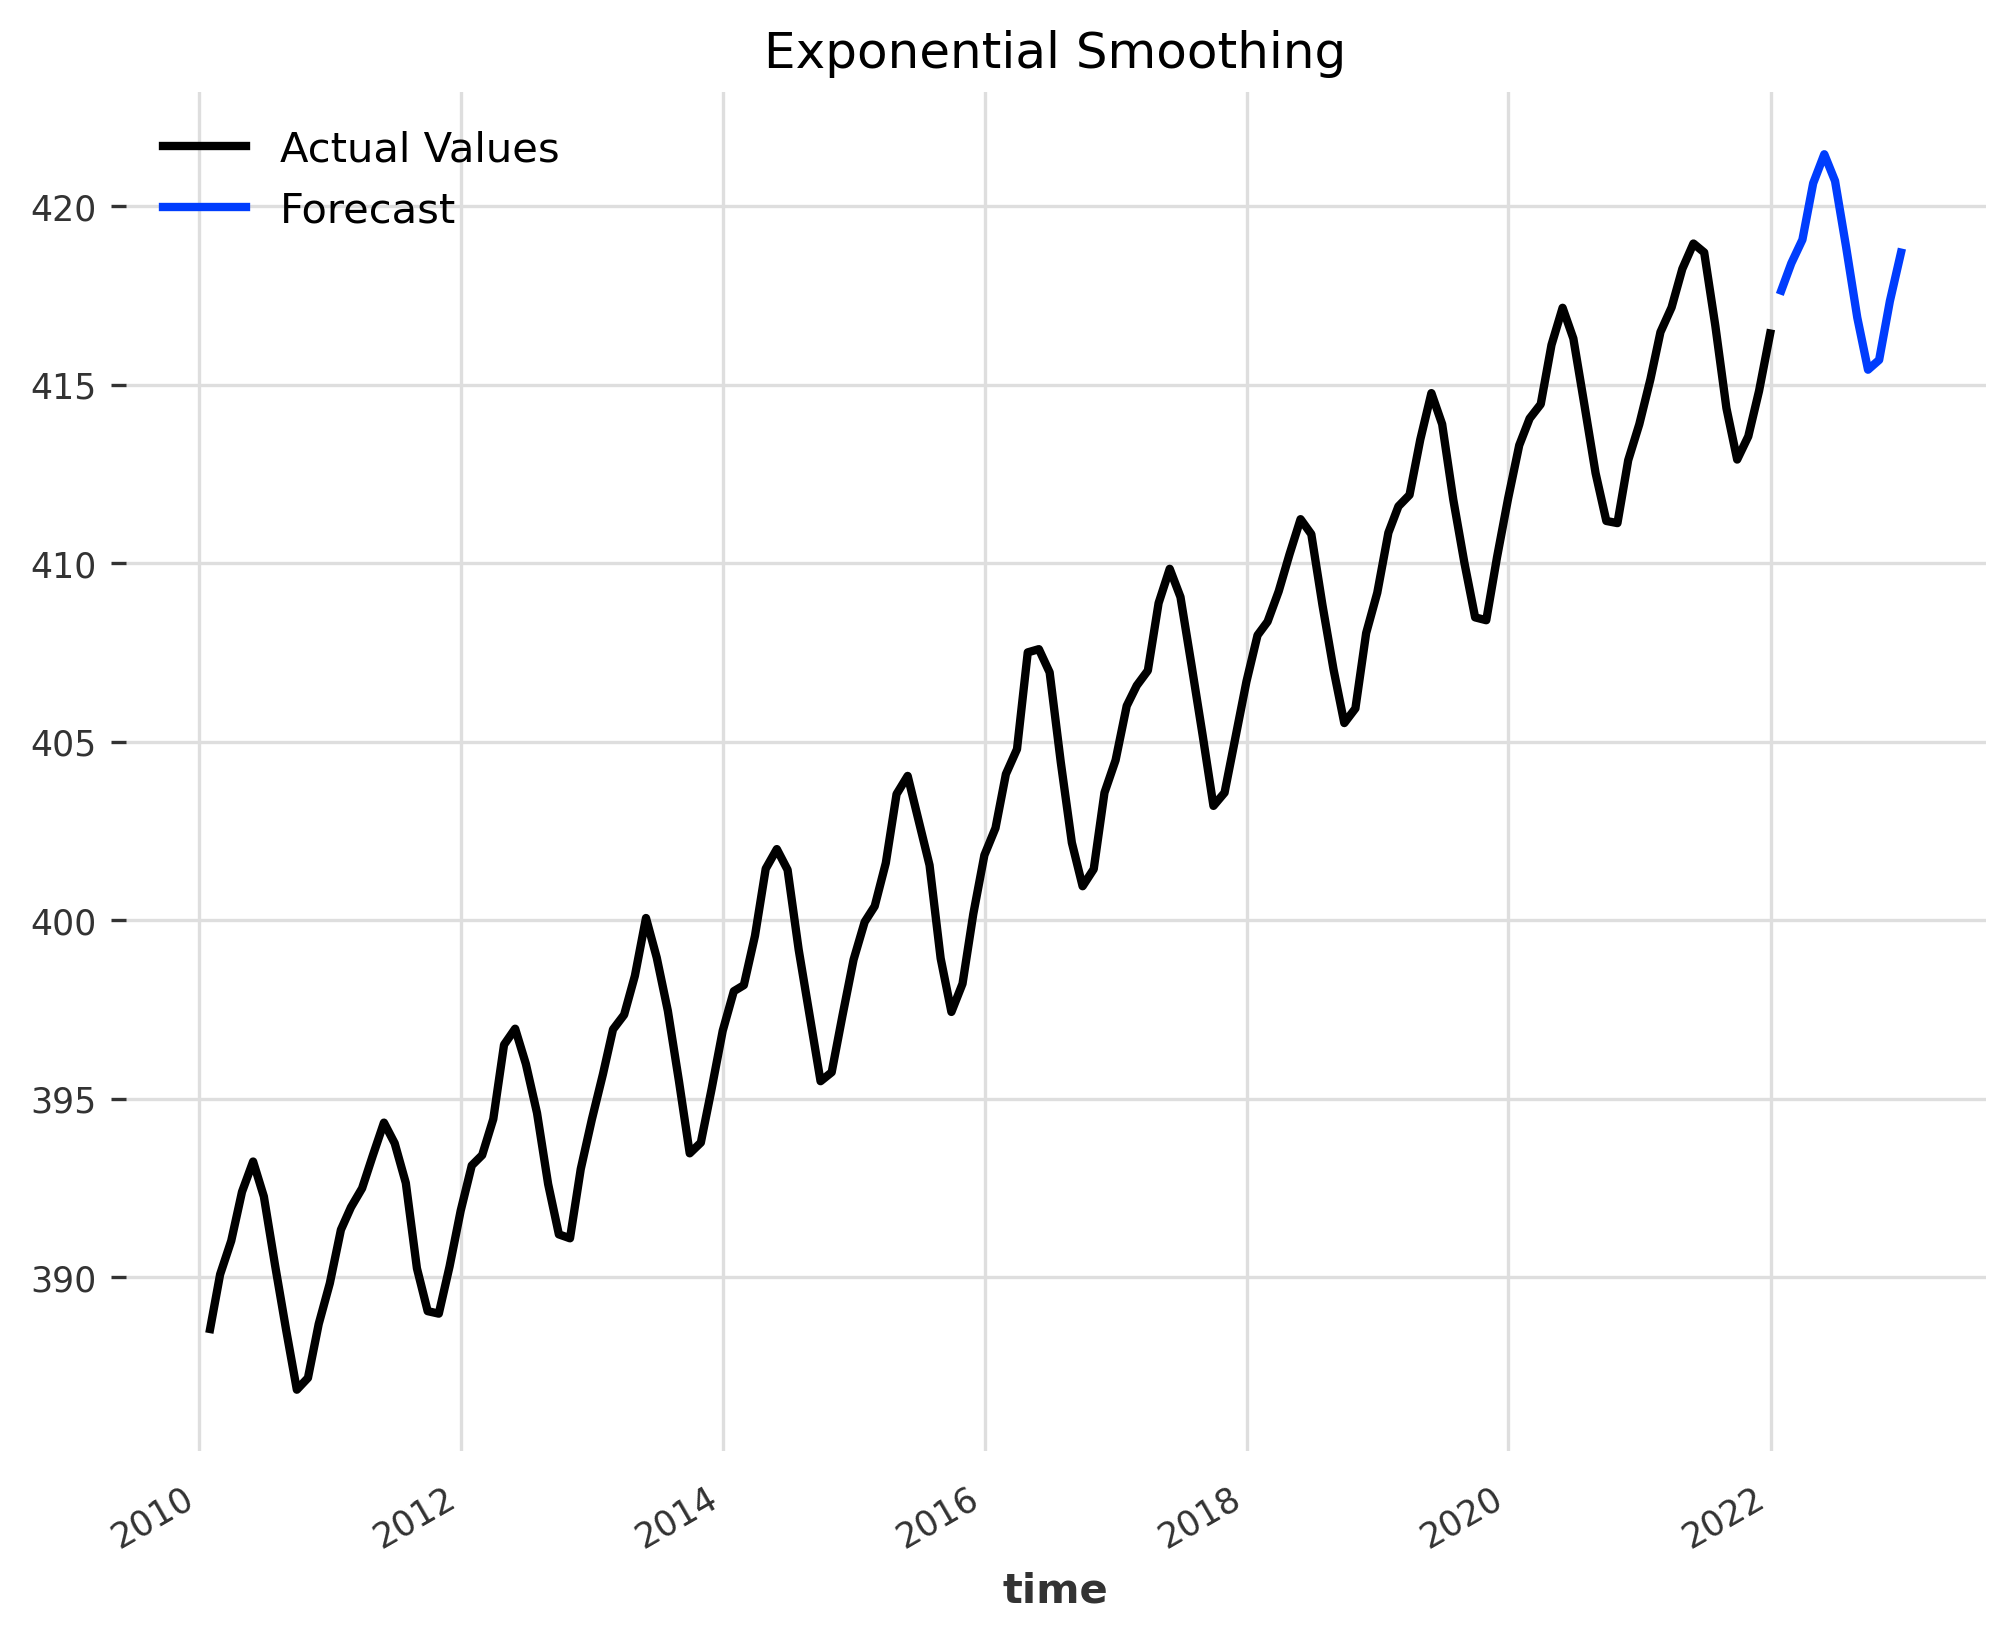

component          CO2
time                  
2022-01-31  417.632845
2022-02-28  418.396292
2022-03-31  419.057947
2022-04-30  420.637404
2022-05-31  421.450293
2022-06-30  420.702138
2022-07-31  418.846188
2022-08-31  416.877533
2022-09-30  415.416160
2022-10-31  415.689649
2022-11-30  417.336954
2022-12-31  418.695043


In [60]:
model = ExponentialSmoothing(seasonal_periods = 12)
model_name = 'Exponential Smoothing'

model.fit(series)
forecast = model.predict(12)

plot_backtest(series, forecast, model_name)
print(forecast.pd_dataframe())